In [2]:
!pip install jax[cuda12]==0.4.28

DEPRECATION: Loading egg at /home/mrwhite0racle/miniconda3/envs/flax/lib/python3.12/site-packages/flash_attn_jax-0.2.2-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached jax-0.4.28-py3-none-any.whl.metadata (23 kB)
  Using cached jaxlib-0.4.28-cp312-cp312-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached jax_cuda12_plugin-0.4.28-cp312-cp312-manylinux2014_x86_64.whl.metadata (560 bytes)
  Using cached nvidia_cudnn_cu12-8.9.7.29-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached jax_cuda12_pjrt-0.4.28-py3-none-manylinux2014_x86_64.whl.metadata (349 bytes)
Using cached jax-0.4.28-py3-none-any.whl (1.9 MB)
Using cached jax_cuda12_plugin-0.4.28-cp312-cp312-manylinux2014_x86_64.whl (12.4 MB)
Using cached jaxlib-0.4.28-cp312-cp312-manylinux2014_x86_64.whl (77.6 MB)
Using cached jax_cuda12_pjrt-0

In [1]:

%load_ext dotenv
%dotenv

import tqdm
from flax import linen as nn
import jax
from typing import Dict, Callable, Sequence, Any, Union
from dataclasses import field
import jax.numpy as jnp
import tensorflow_datasets as tfds
import grain.python as pygrain
# import tensorflow as tf
import numpy as np
import augmax

import matplotlib.pyplot as plt
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
import optax
from flax import struct                # Flax dataclasses
import time
import os
from datetime import datetime
from flax.training import orbax_utils
import functools
from tensorflow_datasets.core.utils import gcs_utils
gcs_utils._is_gcs_disabled = True

# For CLIP
from transformers import AutoTokenizer, FlaxCLIPTextModel

# Initialization

In [2]:
# Some Optimizations
import ctypes

_libcudart = ctypes.CDLL("libcudart.so")
# Set device limit on the current device
# cudaLimitMaxL2FetchGranularity = 0x05
pValue = ctypes.cast((ctypes.c_int * 1)(), ctypes.POINTER(ctypes.c_int))
_libcudart.cudaDeviceSetLimit(ctypes.c_int(0x05), ctypes.c_int(128))
_libcudart.cudaDeviceGetLimit(pValue, ctypes.c_int(0x05))
assert pValue.contents.value == 128
# tf.compat.v1.ConfigProto.force_gpu_compatible = True

# gpus = tf.config.list_physical_devices("GPU")
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.list_logical_devices("GPU")
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)
        
# print(gpus)

In [3]:
normalizeImage = lambda x: jax.nn.standardize(x, mean=[127.5], std=[127.5])
denormalizeImage = lambda x: (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(jnp.astype(denormalizeImage(imgs[i, :, :, :]), jnp.uint8))
        plt.axis("off")
    plt.show()

class RandomClass():
    def __init__(self, rng: jax.random.PRNGKey):
        self.rng = rng

    def get_random_key(self):
        self.rng, subkey = jax.random.split(self.rng)
        return subkey
    
    def get_sigmas(self, steps):
        return jnp.tan(self.theta_min + steps * (self.theta_max - self.theta_min)) / self.kappa

    def reset_random_key(self):
        self.rng = jax.random.PRNGKey(42)

class MarkovState(struct.PyTreeNode):
    pass

class RandomMarkovState(MarkovState):
    rng: jax.random.PRNGKey

    def get_random_key(self):
        rng, subkey = jax.random.split(self.rng)
        return RandomMarkovState(rng), subkey

# Data Pipeline

In [4]:
def defaultTextEncodeModel():
    modelname = "openai/clip-vit-large-patch14"
    model = FlaxCLIPTextModel.from_pretrained(modelname, dtype=jnp.float16)
    tokenizer = AutoTokenizer.from_pretrained(modelname, dtype=jnp.float16)
    return model, tokenizer

def encodePrompts(prompts, model, tokenizer=None):
    if model == None:
        model, tokenizer = defaultTextEncodeModel()
    if tokenizer == None:
        tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")

    # inputs = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="np")
    inputs = tokenizer(prompts, padding="max_length", max_length=12, truncation=True, return_tensors="np")

    outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    pooler_output = outputs.pooler_output  # pooled (EOS token) states
    embed_pooled = pooler_output.astype(jnp.float16)
    embed_labels_full = last_hidden_state.astype(jnp.float16)
    
    return embed_pooled, embed_labels_full

In [5]:
def load_labels_oxford_flowers102(path):
    def load_labels():
        with open(path, "r") as f:
            textlabels = [i.strip() for i in f.readlines()]
        return textlabels
    return load_labels

# Configure the following for your datasets
dataToLabelGenMap = {
    "oxford_flowers102": load_labels_oxford_flowers102("/home/mrwhite0racle/tensorflow_datasets/oxford_flowers102/2.1.1/label.labels.txt"),
}

def get_dataset(data_name="oxford_flowers102", batch_size=64, image_scale=256, method=jax.image.ResizeMethod.LANCZOS3):
    data_source = tfds.data_source(data_name, split="all", try_gcs=False)
    
    gpu_device = jax.devices("gpu")[0]
    cpu_device = jax.devices("cpu")[0]
    
    print(f"Gpu Device: {gpu_device}, Cpu Device: {cpu_device}")
        
    def preprocess(image):
        # image = jax.device_put(image, device=jax.devices("cpu")[0])
        image = (image - 127.5) / 127.5
        image = jax.image.resize(image, (image_scale, image_scale, 3), method=method)
        image = jnp.clip(image, -1.0, 1.0)
        image = jax.device_put(image, device=jax.devices("gpu")[0]) 
        return  image
    
    preprocess = jax.jit(preprocess, backend="cpu")

    augments = augmax.Chain(
        augmax.HorizontalFlip(0.5),
        augmax.RandomContrast((-0.05, 0.05), 1.),
        augmax.RandomBrightness((-0.2, 0.2), 1.)
    )

    augments = jax.jit(augments, backend="cpu")
    
    if os.path.exists(f"./datacache/{data_name}_labels.pkl"):
        print("Loading labels from cache")
        with open(f"./datacache/{data_name}_labels.pkl", "rb") as f:
            import pickle
            embed = pickle.load(f)
            embed_labels = embed["embed_labels"]
            embed_labels_full = embed["embed_labels_full"]
            null_labels = embed["null_labels"]
            null_labels_full = embed["null_labels_full"]
    else:
        print("No cache found, generating labels")
        textlabels = dataToLabelGenMap[data_name]()
        
        model, tokenizer = defaultTextEncodeModel()

        embed_labels, embed_labels_full = encodePrompts(textlabels, model, tokenizer)
        embed_labels = embed_labels.tolist()
        embed_labels_full = embed_labels_full.tolist()
        
        null_labels, null_labels_full = encodePrompts([""], model, tokenizer)
        null_labels = null_labels.tolist()[0]
        null_labels_full = null_labels_full.tolist()[0]
        
        os.makedirs("./datacache", exist_ok=True)
        with open(f"./datacache/{data_name}_labels.pkl", "wb") as f:
            import pickle
            pickle.dump({
                "embed_labels": embed_labels,
                "embed_labels_full": embed_labels_full,
                "null_labels": null_labels,
                "null_labels_full": null_labels_full
                }, f)
        
    embed_labels = [np.array(i, dtype=np.float16) for i in embed_labels]
    embed_labels_full = [np.array(i, dtype=np.float16) for i in embed_labels_full]
    null_labels = np.array(null_labels, dtype=np.float16)
    null_labels_full  = np.array(null_labels_full, dtype=np.float16)
    
    def labelizer(labelidx:int) -> jnp.array:
        label_pooled = embed_labels[labelidx]
        label_seq = embed_labels_full[labelidx]
        # label_pooled = jax.device_put(label_pooled, device=jax.devices("gpu")[0])
        # label_seq = jax.device_put(label_seq, device=jax.devices("gpu")[0])
        return label_pooled, label_seq

    class augmenter(pygrain.RandomMapTransform):
        def random_map(self, element: Dict[str, Any], rng: np.random.Generator) ->  Dict[str, jnp.array]:
            image = element['image']
            image = preprocess(image)
            image = augments(rng.integers(0, 2**32, [2], dtype=np.uint32), image) 
            labelidx = element['label']
            label, label_seq = labelizer(labelidx)
            # image, label = move2gpu(image, label)
            return {'image':image, 'label':label, 'label_seq':label_seq}

    sampler = pygrain.IndexSampler(
        num_records=len(data_source),
        shuffle=True,
        seed=0,
        num_epochs=None,
        shard_options=pygrain.ShardByJaxProcess(),
    )

    transformations = [augmenter(), pygrain.Batch(batch_size, drop_remainder=True)]

    loader = pygrain.DataLoader(
        data_source=data_source,
        sampler=sampler,
        operations=transformations,
        worker_count=4,
        read_options=pygrain.ReadOptions(8, 500),
        worker_buffer_size=5
        )
    return {
        "loader": loader,
        "null_labels": null_labels,
        "null_labels_full": null_labels_full,
        "embed_labels": embed_labels,
        "embed_labels_full": embed_labels_full,
        "length": len(data_source),  
        "batch_size": batch_size,
        "image_size": image_scale
    }


In [11]:
data = get_dataset("oxford_flowers102", batch_size=32, image_scale=128)

Gpu Device: cuda:0, Cpu Device: TFRT_CPU_0
Loading labels from cache


In [ ]:
a = None
for batch in data['loader']:
    # print(batch.shape)
    plotImages(batch['image'], dpi=300)
    a = batch
    print(batch['label'].shape, batch['label_seq'].shape)
    # time.sleep(0.1)
    break

In [14]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        i = 0
        for sample in tqdm.tqdm(dataset):
            # Performing a training step
            time.sleep(0.01)
            i += 1
        print(i)
    print("Execution time:", time.perf_counter() - start_time)

In [ ]:
benchmark(data)

# Noise Samplers

In [6]:
from flaxdiff.schedulers import CosineNoiseSchedule, NoiseScheduler, GeneralizedNoiseScheduler, KarrasVENoiseScheduler, EDMNoiseScheduler
from flaxdiff.predictors import VPredictionTransform, EpsilonPredictionTransform, DiffusionPredictionTransform, DirectPredictionTransform, KarrasPredictionTransform

# Modeling

## Metrics

## Callbacks

## Model Generator

In [7]:
# import jax.experimental.pallas.ops.gpu.attention
import jax.experimental.pallas.ops.attention

from flaxdiff.models.simple_unet import l2norm, ConvLayer, TimeEmbedding, TimeProjection, Upsample, Downsample, ResidualBlock, PixelShuffle
from flaxdiff.models.simple_unet import FourierEmbedding

from flaxdiff.models.attention import kernel_init
from flash_attn_jax import flash_mha
from flaxdiff.models.favor_fastattn import make_fast_generalized_attention, make_fast_softmax_attention

# Kernel initializer to use
def kernel_init(scale, dtype=jnp.float32):
    scale = max(scale, 1e-10)
    return nn.initializers.variance_scaling(scale=scale, mode="fan_avg", distribution="truncated_normal", dtype=dtype)

class FlashAttention(nn.Module):
    """
    Based on the flash attention implementation.
    """
    query_dim: int
    heads: int = 4
    dim_head: int = 64
    dtype: Any = jnp.float32
    precision: Any = jax.lax.Precision.HIGHEST
    use_bias: bool = True
    kernel_init: Callable = lambda : kernel_init(1.0)

    def setup(self):
        inner_dim = self.dim_head * self.heads
        # Weights were exported with old names {to_q, to_k, to_v, to_out}
        self.query = nn.DenseGeneral(inner_dim, use_bias=False, precision=self.precision, 
                                     kernel_init=self.kernel_init(), dtype=self.dtype, name="to_q")
        self.key = nn.DenseGeneral(inner_dim, use_bias=False, precision=self.precision, 
                                     kernel_init=self.kernel_init(), dtype=self.dtype, name="to_k")
        self.value = nn.DenseGeneral(inner_dim, use_bias=False, precision=self.precision, 
                                     kernel_init=self.kernel_init(), dtype=self.dtype, name="to_v")
        self.proj_attn = nn.DenseGeneral(self.query_dim, use_bias=False, precision=self.precision, 
                                     kernel_init=self.kernel_init(), dtype=self.dtype, name="to_out_0")
        self.attnfn = make_fast_generalized_attention(qkv_dim=inner_dim, lax_scan_unroll=16)

    @nn.compact
    def __call__(self, x:jax.Array, context=None):
        # x has shape [B, H * W, C]
        context = x if context is None else context
        query = self.query(x)
        key = self.key(context)
        value = self.value(context)
        
        # hidden_states = flash_mha(
        #     query.astype(jnp.float16), key.astype(jnp.float16), value.astype(jnp.float16),
        # )
        
        # hidden_states = jax.experimental.pallas.ops.attention.mha_reference(
        #     query, key, value, None
        # )
        
        # hidden_states = self.attnfn(
        #     query, key, value, None
        # )

        hidden_states = nn.dot_product_attention(
            query, key, value, dtype=self.dtype, broadcast_dropout=False, dropout_rng=None, precision=self.precision
        )
        
        proj = self.proj_attn(hidden_states)
        return proj


class NormalAttention(nn.Module):
    """
    Simple implementation of the normal attention.
    """
    query_dim: int
    heads: int = 4
    dim_head: int = 64
    dtype: Any = jnp.float32
    precision: Any = jax.lax.Precision.HIGHEST
    use_bias: bool = True
    kernel_init: Callable = lambda : kernel_init(1.0)

    def setup(self):
        inner_dim = self.dim_head * self.heads
        dense = functools.partial(
            nn.DenseGeneral,
            features=[self.heads, self.dim_head], 
            axis=-1, 
            precision=self.precision, 
            use_bias=self.use_bias, 
            kernel_init=self.kernel_init(), 
            dtype=self.dtype
        )
        self.query = dense(name="to_q")
        self.key = dense(name="to_k")
        self.value = dense(name="to_v")

        self.proj_attn = nn.DenseGeneral(
            self.query_dim, 
            axis=(-2, -1), 
            precision=self.precision, 
            use_bias=self.use_bias, 
            dtype=self.dtype, 
            name="to_out_0",
            kernel_init=self.kernel_init()
            # kernel_init=jax.nn.initializers.xavier_uniform()
        )

    @nn.compact
    def __call__(self, x, context=None):
        # x has shape [B, H, W, C]
        context = x if context is None else context
        query = self.query(x)
        key = self.key(context)
        value = self.value(context)
        
        hidden_states = nn.dot_product_attention(
            query, key, value, dtype=self.dtype, broadcast_dropout=False, dropout_rng=None, precision=self.precision
        )
        proj = self.proj_attn(hidden_states)
        return proj

class AttentionBlock(nn.Module):
    heads: int = 4
    dim_head: int = 32
    use_linear_attention: bool = True
    dtype: Any = jnp.float32
    precision: Any = jax.lax.Precision.HIGH
    use_projection: bool = False
    use_flash_attention:bool = False

    @nn.compact
    def __call__(self, x, context=None):
        inner_dim = self.heads * self.dim_head
        B, H, W, C = x.shape
        normed_x = nn.RMSNorm(epsilon=1e-5, dtype=self.dtype)(x)
        # normed_x = nn.LayerNorm(epsilon=1e-5, dtype=self.dtype)(x)
        if self.use_projection == True:
            if self.use_linear_attention:
                projected_x = nn.Dense(features=inner_dim, 
                                       use_bias=False, precision=self.precision, 
                                       kernel_init=kernel_init(1.0),
                                       dtype=self.dtype, name=f'project_in')(normed_x)
            else:
                projected_x = nn.Conv(
                    features=inner_dim, kernel_size=(1, 1),
                    kernel_init=kernel_init(1.0),
                    strides=(1, 1), padding='VALID', use_bias=False, dtype=self.dtype,
                    precision=self.precision, name=f'project_in_conv',
                )(normed_x)
        else:
            projected_x = normed_x
            inner_dim = C
            
        context = projected_x if context is None else context

        if self.use_flash_attention == True:
            projected_x = FlashAttention(
                query_dim=inner_dim,
                heads=self.heads,
                dim_head=self.dim_head,
                name=f'Attention',
                precision=self.precision,
                use_bias=False,
                dtype=self.dtype,
            )(projected_x, context)
        else:
            projected_x = NormalAttention(
                query_dim=inner_dim,
                heads=self.heads,
                dim_head=self.dim_head,
                name=f'Attention',
                precision=self.precision,
                use_bias=False,
            )(projected_x, context)

        # projected_x = nn.MultiHeadAttention(num_heads=self.heads, use_bias=False, precision='high', decode=False)(projected_x)

        # projected_x = BasicTransformerBlock(
        #     query_dim=inner_dim,
        #     heads=self.heads,
        #     dim_head=self.dim_head,
        #     name=f'Attention',
        #     precision=self.precision,
        # )(projected_x, projected_x)

        if self.use_projection == True:
            if self.use_linear_attention:
                projected_x = nn.Dense(features=C, precision=self.precision, 
                                       dtype=self.dtype, use_bias=False, 
                                       kernel_init=kernel_init(1.0),
                                       name=f'project_out')(projected_x)
            else:
                projected_x = nn.Conv(
                    features=C, kernel_size=(1, 1),
                    kernel_init=kernel_init(1.0),
                    strides=(1, 1), padding='VALID', use_bias=False, dtype=self.dtype,
                    precision=self.precision, name=f'project_out_conv',
                )(projected_x)

        out = x + projected_x
        return out


## Attention and other prototyping

In [8]:
x = jnp.ones((16, 16, 16, 64))
# context = jnp.ones((8, 16, 16, 64))
attention_block = AttentionBlock(heads=4, dim_head=64//4, dtype=jnp.float16, use_flash_attention=True)
params = attention_block.init(jax.random.PRNGKey(0), x)
# %timeit attention_block.apply(params, x)

In [ ]:
x = jnp.ones((1, 16, 16, 64))
context = jnp.ones((1, 12, 768))
# pad the context
context = jnp.pad(context, ((0, 0), (0, 4), (0, 0)), mode='constant', constant_values=0)
print(context.shape)
context = jnp.reshape(context, (1, 1, 16, 768))
attention_block = AttentionBlock(heads=4, dim_head=64//4, dtype=jnp.float16, use_flash_attention=True)
params = attention_block.init(jax.random.PRNGKey(0), x, context)
out = attention_block.apply(params, x, context)
print("Output :", out.shape)
print(attention_block.tabulate(jax.random.key(0), x, context, console_kwargs={"width": 200, "force_jupyter":True, }))
print(jnp.mean(out), jnp.std(out))
# plt.hist(out.flatten(), bins=100)
# %timeit attention_block.apply(params, x)

## Main Model

In [8]:
class ResidualBlock(nn.Module):
    conv_type:str
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    padding:str="SAME"
    activation:Callable=jax.nn.swish
    direction:str=None
    res:int=2
    norm_groups:int=8
    kernel_init:Callable=kernel_init(1.0)

    @nn.compact
    def __call__(self, x:jax.Array, temb:jax.Array, textemb:jax.Array=None, extra_features:jax.Array=None):
        residual = x
        out = nn.GroupNorm(self.norm_groups)(x)
        out = self.activation(out)

        out = ConvLayer(
            self.conv_type,
            features=self.features,
            kernel_size=self.kernel_size,
            strides=self.strides,
            kernel_init=self.kernel_init,
            name="conv1"
        )(out)

        temb = nn.DenseGeneral(features=self.features, name="temb_projection")(temb)
        temb = jnp.expand_dims(jnp.expand_dims(temb, 1), 1)
        # scale, shift = jnp.split(temb, 2, axis=-1)
        # out = out * (1 + scale) + shift
        out = out + temb

        out = nn.GroupNorm(self.norm_groups)(out)
        out = self.activation(out)

        out = ConvLayer(
            self.conv_type,
            features=self.features,
            kernel_size=self.kernel_size,
            strides=self.strides,
            kernel_init=self.kernel_init,
            name="conv2"
        )(out)

        if residual.shape != out.shape:
            residual = ConvLayer(
                self.conv_type,
                features=self.features,
                kernel_size=(1, 1),
                strides=1,
                kernel_init=self.kernel_init,
                name="residual_conv"
            )(residual)
        out = out + residual

        out = jnp.concatenate([out, extra_features], axis=-1) if extra_features is not None else out

        return out
    
class Unet(nn.Module):
    emb_features:int=64*4,
    feature_depths:list=[64, 128, 256, 512],
    attention_configs:list=[{"heads":8}, {"heads":8}, {"heads":8}, {"heads":8}],
    num_res_blocks:int=2,
    num_middle_res_blocks:int=1,
    activation:Callable = jax.nn.swish
    norm_groups:int=8

    @nn.compact
    def __call__(self, x, temb, textcontext=None):
        # print("embedding features", self.emb_features)
        temb = FourierEmbedding(features=self.emb_features)(temb)
        temb = TimeProjection(features=self.emb_features)(temb)
        
        # textemb = textcontext
        # textemb = nn.DenseGeneral(features=self.emb_features, name="textemb_projection")(textemb)
        # textemb = nn.gelu(textemb)
        
        # B, S = textemb.shape
        # textcontext = textemb.reshape((B, 1, S))
        _, TS, TC = textcontext.shape
        
        # print("time embedding", temb.shape)
        feature_depths = self.feature_depths
        attention_configs = self.attention_configs

        conv_type = up_conv_type = down_conv_type = middle_conv_type = "conv"
        # middle_conv_type = "separable"

        x = ConvLayer(
            conv_type,
            features=self.feature_depths[0],
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_init=kernel_init(1.0)
        )(x)
        downs = [x]

        # Downscaling blocks
        for i, (dim_out, attention_config) in enumerate(zip(feature_depths, attention_configs)):
            dim_in = x.shape[-1]
            # dim_in = dim_out
            for j in range(self.num_res_blocks):
                x = ResidualBlock(
                    down_conv_type,
                    name=f"down_{i}_residual_{j}",
                    features=dim_in,
                    kernel_init=kernel_init(1.0),
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation=self.activation,
                    norm_groups=self.norm_groups
                )(x, temb)
                if attention_config is not None and j == self.num_res_blocks - 1:   # Apply attention only on the last block
                    B, H, W, _ = x.shape
                    if H > TS:
                        padded_context = jnp.pad(textcontext, ((0, 0), (0, H - TS), (0, 0)), mode='constant', constant_values=0).reshape((B, 1, H, TC))
                    else:
                        padded_context = None
                    x = AttentionBlock(heads=attention_config['heads'], dtype=attention_config.get('dtype', jnp.float32),
                                       dim_head=dim_in // attention_config['heads'],
                                       use_flash_attention=attention_config.get("flash_attention", True),
                                       name=f"down_{i}_attention_{j}")(x, padded_context)
                # print("down residual for feature level", i, "is of shape", x.shape, "features", dim_in)
                downs.append(x)
            if i != len(feature_depths) - 1:
                # print("Downsample", i, x.shape)
                x = Downsample(
                    features=dim_out,
                    scale=2,
                    activation=self.activation,
                    name=f"down_{i}_downsample"
                )(x)

        # Middle Blocks
        middle_dim_out = self.feature_depths[-1]
        middle_attention = self.attention_configs[-1]
        # x = nn.GroupNorm(8)(x)
        # x = ConvLayer(
        #     conv_type,
        #     features=middle_dim_out,
        #     kernel_size=(3, 3),
        #     strides=(1, 1),
        #     kernel_init=kernel_init(1.0),
        #     name="middle_conv"
        # )(x)
        for j in range(self.num_middle_res_blocks):
            x = ResidualBlock(
                middle_conv_type,
                name=f"middle_res1_{j}",
                features=middle_dim_out,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
                norm_groups=self.norm_groups
            )(x, temb)
            if middle_attention is not None and j == self.num_middle_res_blocks - 1:   # Apply attention only on the last block
                x = AttentionBlock(heads=middle_attention['heads'], dtype=middle_attention.get('dtype', jnp.float32), 
                                   dim_head=middle_dim_out // middle_attention['heads'],
                                    use_flash_attention=middle_attention.get("flash_attention", True),
                                   use_linear_attention=False,
                                   name=f"middle_attention_{j}")(x)
            x = ResidualBlock(
                middle_conv_type,
                name=f"middle_res2_{j}",
                features=middle_dim_out,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
                norm_groups=self.norm_groups
            )(x, temb)

        # Upscaling Blocks
        for i, (dim_out, attention_config) in enumerate(zip(reversed(feature_depths), reversed(attention_configs))):
            # print("Upscaling", i, "features", dim_out)
            for j in range(self.num_res_blocks):
                x = jnp.concatenate([x, downs.pop()], axis=-1)
                # print("concat==> ", i, "concat", x.shape)
                # kernel_size = (1 + 2 * (j + 1), 1 + 2 * (j + 1))
                kernel_size = (3, 3)
                x = ResidualBlock(
                    up_conv_type,# if j == 0 else "separable",
                    name=f"up_{i}_residual_{j}",
                    features=dim_out,
                    kernel_init=kernel_init(1.0),
                    kernel_size=kernel_size,
                    strides=(1, 1),
                    activation=self.activation,
                    norm_groups=self.norm_groups
                )(x, temb)
                if attention_config is not None and j == self.num_res_blocks - 1:   # Apply attention only on the last block
                    B, H, W, _ = x.shape
                    if H > TS:
                        padded_context = jnp.pad(textcontext, ((0, 0), (0, H - TS), (0, 0)), mode='constant', constant_values=0).reshape((B, 1, H, TC))
                    else:
                        padded_context = None
                    x = AttentionBlock(heads=attention_config['heads'], dtype=attention_config.get('dtype', jnp.float32), 
                                       dim_head=dim_out // attention_config['heads'],
                                       use_flash_attention=attention_config.get("flash_attention", True),
                                       name=f"up_{i}_attention_{j}")(x, padded_context)
            # print("Upscaling ", i, x.shape)
            if i != len(feature_depths) - 1:
                x = Upsample(
                    features=feature_depths[-i],
                    scale=2,
                    activation=self.activation,
                    name=f"up_{i}_upsample"
                )(x)

        # x = nn.GroupNorm(8)(x)
        x = ConvLayer(
            conv_type,
            features=self.feature_depths[0],
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_init=kernel_init(0.0)
        )(x)
    
        x = jnp.concatenate([x, downs.pop()], axis=-1)

        x = ResidualBlock(
            conv_type,
            name="final_residual",
            features=self.feature_depths[0],
            kernel_init=kernel_init(1.0),
            kernel_size=(3,3),
            strides=(1, 1),
            activation=self.activation,
            norm_groups=self.norm_groups
        )(x, temb)

        x = nn.GroupNorm(self.norm_groups)(x)
        x = self.activation(x)

        noise_out = ConvLayer(
            conv_type,
            features=3,
            kernel_size=(3, 3),
            strides=(1, 1),
            # activation=jax.nn.mish
            kernel_init=kernel_init(0.0)
        )(x)
        return noise_out#, attentions

# Training

In [9]:
BATCH_SIZE = 16
IMAGE_SIZE = 128

cosine_schedule = CosineNoiseSchedule(1000, beta_end=1)
karas_ve_schedule = KarrasVENoiseScheduler(1, sigma_max=80, rho=7, sigma_data=0.5)
edm_schedule = EDMNoiseScheduler(1, sigma_max=80, rho=7, sigma_data=0.5)

In [10]:
import orbax.checkpoint

@struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output('loss') # type: ignore

class ModelState():
    model: nn.Module
    params: dict
    noise_schedule: NoiseScheduler
    model_output_transform: DiffusionPredictionTransform

# Define the TrainState with EMA parameters
class TrainState(train_state.TrainState):
    rngs: jax.random.PRNGKey
    ema_params: dict

    def get_random_key(self):
        rngs, subkey = jax.random.split(self.rngs)
        return self.replace(rngs=rngs), subkey

    def apply_ema(self, decay: float=0.999):
        new_ema_params = jax.tree_util.tree_map(
            lambda ema, param: decay * ema + (1 - decay) * param,
            self.ema_params,
            self.params,
        )
        return self.replace(ema_params=new_ema_params)

class DiffusionTrainer:
    state : TrainState
    best_state : TrainState
    best_loss : float
    model : nn.Module
    noise_schedule : NoiseScheduler
    model_output_transform:DiffusionPredictionTransform
    ema_decay:float = 0.999
    
    def __init__(self, 
                 model:nn.Module, 
                 optimizer: optax.GradientTransformation,
                 noise_schedule:NoiseScheduler,
                 rngs:jax.random.PRNGKey,
                 image_size:int=64,
                 unconditional_prob:float=0.2,
                 train_state:TrainState=None,
                 name:str="Diffusion",
                 load_from_checkpoint:bool=False,
                 checkpoint_suffix:str="",
                 param_transforms:Callable=None,
                 model_output_transform:DiffusionPredictionTransform=EpsilonPredictionTransform(),
                 loss_fn=optax.l2_loss
                 ):
        self.model = model
        self.noise_schedule = noise_schedule
        self.name = name
        self.model_output_transform = model_output_transform
        self.loss_fn = loss_fn
        self.image_size = image_size
        self.unconditional_prob = unconditional_prob

        checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=4, create=True)
        self.checkpointer = orbax.checkpoint.CheckpointManager(self.checkpoint_path() + checkpoint_suffix, checkpointer, options)

        if load_from_checkpoint:
            latest_step, old_state, old_best_state = self.load()
        else:
            latest_step, old_state, old_best_state = 0, None, None
            
        self.latest_step = latest_step

        if train_state == None:
            self.init_state(optimizer, rngs, existing_state=old_state, existing_best_state=old_best_state, model=model, param_transforms=param_transforms)
        else:
            self.state = train_state
            self.best_state = train_state
            self.best_loss = 1e9

    def init_state(self, 
                   optimizer: optax.GradientTransformation, 
                   rngs:jax.random.PRNGKey,
                   existing_state:dict=None,
                   existing_best_state:dict=None,
                   model:nn.Module=None,
                    param_transforms:Callable=None,
                   ):
        inp = jnp.ones((1, self.image_size, self.image_size, 3))
        temb = jnp.ones((1,))
        textcontext = jnp.ones((1, 12, 768))
        rngs, subkey = jax.random.split(rngs)

        if existing_state == None:
            params = model.init(subkey, inp, temb, textcontext)
            existing_state = {"params":params, "ema_params":params}

        if param_transforms is not None:
            params = param_transforms(params)
        self.best_loss = 1e9
        self.state = TrainState.create(
            apply_fn=model.apply,
            params=existing_state['params'],
            ema_params=existing_state['ema_params'],
            tx=optimizer,
            rngs=rngs,
        )
        if existing_best_state is not None:
            self.best_state = self.state.replace(params=existing_best_state['params'], ema_params=existing_best_state['ema_params'])
        else:
            self.best_state = self.state

    def checkpoint_path(self):
        experiment_name = self.name
        path = os.path.join(os.path.abspath('./checkpoints'), experiment_name)
        if not os.path.exists(path):
            os.makedirs(path)
        return path

    def load(self):
        step = self.checkpointer.latest_step()
        print("Loading model from checkpoint", step)
        ckpt = self.checkpointer.restore(step)
        state = ckpt['state']
        best_state = ckpt['best_state']
        # Convert the state to a TrainState
        self.best_loss = ckpt['best_loss']
        print(f"Loaded model from checkpoint at step {step}", ckpt['best_loss'])
        return step, state, best_state

    def save(self, epoch=0):
        print(f"Saving model at epoch {epoch}")
        # filename = os.path.join(self.checkpoint_path(), f'model_{epoch}' if not best else 'best_model')
        ckpt = {
            'model': self.model,
            'state': self.state,
            'best_state': self.best_state,
            'best_loss': self.best_loss
        }
        save_args = orbax_utils.save_args_from_target(ckpt)
        self.checkpointer.save(epoch, ckpt, save_kwargs={'save_args': save_args}, force=True)

    def summary(self):
        inp = jnp.ones((1, self.image_size, self.image_size, 3))
        temb = jnp.ones((1,))
        textcontext = jnp.ones((1, 12, 768))
        print(self.model.tabulate(jax.random.key(0), inp, temb, textcontext, console_kwargs={"width": 200, "force_jupyter":True, }))

    def _define_train_step(self, batch_size, null_labels_seq):
        noise_schedule = self.noise_schedule
        model = self.model
        model_output_transform = self.model_output_transform
        loss_fn = self.loss_fn
        unconditional_prob = self.unconditional_prob
        
        # Determine the number of unconditional samples
        num_unconditional = int(batch_size * unconditional_prob)
        
        nS, nC = null_labels_seq.shape
        null_labels_seq = jnp.broadcast_to(null_labels_seq, (batch_size, nS, nC))
        
        @jax.jit
        def train_step(state:TrainState, batch):
            """Train for a single step."""
            images = batch['image']
            label_seq = batch['label_seq']
            
            # Generate random probabilities to decide how much of this batch will be unconditional
            # state, rngs = state.get_random_key()
            # random_prob = jax.random.uniform(rngs, (batch_size,), dtype=jnp.float16)
            # is_unconditional = random_prob < unconditional_prob
            # # Replace label_seq with null_labels_seq based on the probability
            # label_seq = jax.lax.select(is_unconditional[:, None, None], null_labels_seq, label_seq)
            
            label_seq = jnp.concat([null_labels_seq[:num_unconditional], label_seq[num_unconditional:]], axis=0)

            noise_level, state = noise_schedule.generate_timesteps(images.shape[0], state)
            state, rngs = state.get_random_key()
            noise:jax.Array = jax.random.normal(rngs, shape=images.shape)
            rates = noise_schedule.get_rates(noise_level)
            noisy_images, c_in, expected_output = model_output_transform.forward_diffusion(images, noise, rates)
            def model_loss(params):
                preds = model.apply(params, *noise_schedule.transform_inputs(noisy_images*c_in, noise_level), label_seq)
                preds = model_output_transform.pred_transform(noisy_images, preds, rates)
                nloss = loss_fn(preds, expected_output)
                # nloss = jnp.mean(nloss, axis=1)
                nloss *= noise_schedule.get_weights(noise_level)
                nloss = jnp.mean(nloss)
                loss = nloss
                return loss
            loss, grads = jax.value_and_grad(model_loss)(state.params)
            state = state.apply_gradients(grads=grads) 
            state = state.apply_ema(self.ema_decay)
            return state, loss
        return train_step
    
    def _define_compute_metrics(self):
        @jax.jit
        def compute_metrics(state:TrainState, expected, pred):
            loss = jnp.mean(jnp.square(pred - expected))
            metric_updates = state.metrics.single_from_model_output(loss=loss)
            metrics = state.metrics.merge(metric_updates)
            state = state.replace(metrics=metrics)
            return state
        return compute_metrics

    def fit(self, data, steps_per_epoch, epochs):
        loader = data['loader']
        null_labels_full = data['null_labels_full']
        batch_size = data['batch_size']
        loader = iter(loader)
        train_step = self._define_train_step(batch_size, null_labels_full)
        compute_metrics = self._define_compute_metrics()
        state = self.state
        for epoch in range(epochs):
            current_epoch = self.latest_step + epoch + 1
            print(f"\nEpoch {current_epoch}/{epochs}")
            start_time = time.time()
            epoch_loss = 0
            with tqdm.tqdm(total=steps_per_epoch, desc=f'\t\tEpoch {current_epoch}', ncols=100, unit='step') as pbar:
                for i in range(steps_per_epoch):
                    batch = next(loader)
                    state, loss = train_step(state, batch)
                    epoch_loss += loss
                    if i % 100 == 0:
                        pbar.set_postfix(loss=f'{loss:.4f}')
                        pbar.update(100)
            end_time = time.time()
            self.state = state
            total_time = end_time - start_time
            avg_time_per_step = total_time / steps_per_epoch
            avg_loss = epoch_loss / steps_per_epoch
            if avg_loss < self.best_loss:
                self.best_loss = avg_loss
                self.best_state = state
                self.save(current_epoch)
            print(f"\n\tEpoch {current_epoch} completed. Avg Loss: {avg_loss}, Time: {total_time:.2f}s, Best Loss: {self.best_loss}")
        self.save(epochs)
        return self.state


In [11]:
experiment_name = "{name}_{date}".format(
    name="Diffusion_SDE_VE_TEXT", date=datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
)
# experiment_name = 'Diffusion_SDE_VE_TEXT_2024-07-15_02:31:13'
print("Experiment_Name:", experiment_name)
unet = Unet(emb_features=256, 
            feature_depths=[64, 64, 128, 256, 512],
            attention_configs=[
                None, #{"heads":8, "dtype":jnp.float16, "flash_attention":True}, 
                {"heads":8, "dtype":jnp.float16, "flash_attention":True}, 
                {"heads":8, "dtype":jnp.float16, "flash_attention":True}, 
                {"heads":8, "dtype":jnp.float16, "flash_attention":True}, 
                {"heads":8, "dtype":jnp.float16, "flash_attention":False}
                ],
            num_res_blocks=2,
            num_middle_res_blocks=1
)

data = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
datalen = data['length']
batches = datalen // BATCH_SIZE

# Suggested configurations
total_epochs = 2000
steps_per_epoch = batches
init_value = 1e-6
peak_value = 2e-4
warmup_steps = steps_per_epoch * 5
decay_steps = total_epochs * steps_per_epoch - warmup_steps
end_value = 1e-6
exponent = 1.0

# # Create the learning rate schedule
# learning_rate_schedule = optax.warmup_cosine_decay_schedule(
#     init_value=init_value,
#     peak_value=peak_value,
#     warmup_steps=warmup_steps,
#     decay_steps=decay_steps,
#     end_value=end_value,
#     exponent=exponent
# )

# solver = optax.adamw(learning_rate=learning_rate_schedule)
# solver = optax.radam(2e-4)
solver = optax.adam(2e-4)
# solver = optax.adamw(1e-5)

# solver = optax.lookahead(solver, sync_period=6, slow_step_size=0.5)
# params_transform = lambda x: optax.LookaheadParams.init_synced(x)

trainer = DiffusionTrainer(unet, optimizer=solver, 
                           noise_schedule=edm_schedule,
                           rngs=jax.random.PRNGKey(4), 
                           name=experiment_name,
                           model_output_transform=KarrasPredictionTransform(sigma_data=edm_schedule.sigma_data),
                           image_size=IMAGE_SIZE,
                        #    train_state=trainer.best_state,
                        #    loss_fn=lambda x, y: jnp.abs(x - y),
                            # param_transforms=params_transform,
                        #    load_from_checkpoint=True,
                           )
#trainer.summary()

Experiment_Name: Diffusion_SDE_VE_TEXT_2024-07-16_02:16:07
Gpu Device: cuda:0, Cpu Device: TFRT_CPU_0
Loading labels from cache


In [ ]:
data = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
final_state = trainer.fit(data, batches, epochs=2000)

In [32]:
data = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
final_state = trainer.fit(data, batches, epochs=2000)

Gpu Device: cuda:0, Cpu Device: TFRT_CPU_0
Loading labels from cache

Epoch 1/2000


		Epoch 1: 600step [01:35,  6.31step/s, loss=0.1320]                                                


Saving model at epoch 1

	Epoch 1 completed. Avg Loss: 0.2727695405483246, Time: 95.07s, Best Loss: 0.2727695405483246

Epoch 2/2000


		Epoch 2: 600step [00:47, 12.59step/s, loss=0.1248]                                                


Saving model at epoch 2

	Epoch 2 completed. Avg Loss: 0.12622438371181488, Time: 47.65s, Best Loss: 0.12622438371181488

Epoch 3/2000


		Epoch 3: 600step [00:51, 11.75step/s, loss=0.1208]                                                


Saving model at epoch 3

	Epoch 3 completed. Avg Loss: 0.11213485896587372, Time: 51.06s, Best Loss: 0.11213485896587372

Epoch 4/2000


		Epoch 4:  20%|██████▋                           | 100/511 [00:00<00:00, 841.93step/s, loss=0.1320]

In [14]:
trainer.best_loss

Array(0.09960569, dtype=float32)

In [43]:
from flaxdiff.utils import clip_images

def clip_images(images, clip_min=-1, clip_max=1):
    return jnp.clip(images, clip_min, clip_max)
    
class DiffusionSampler():
    model:nn.Module
    noise_schedule:NoiseScheduler
    params:dict
    model_output_transform:DiffusionPredictionTransform

    def __init__(self, model:nn.Module, params:dict,  
                 noise_schedule:NoiseScheduler, 
                 model_output_transform:DiffusionPredictionTransform=EpsilonPredictionTransform(),
                 guidance_scale:float = 0.0,
                 null_labels_seq:jax.Array=None
                 ):
        self.model = model
        self.noise_schedule = noise_schedule
        self.params = params
        self.model_output_transform = model_output_transform
        self.guidance_scale = guidance_scale
        if self.guidance_scale > 0:
            # Classifier free guidance
            assert null_labels_seq is not None, "Null labels sequence is required for classifier-free guidance"
            print("Using classifier-free guidance")
            @jax.jit
            def sample_model(x_t, t, *additional_inputs):
                # Concatenate unconditional and conditional inputs
                x_t_cat = jnp.concatenate([x_t] * 2, axis=0)
                t_cat = jnp.concatenate([t] * 2, axis=0)
                rates_cat = self.noise_schedule.get_rates(t_cat)
                c_in_cat = self.model_output_transform.get_input_scale(rates_cat)
                
                text_labels_seq, = additional_inputs
                text_labels_seq = jnp.concatenate([text_labels_seq, jnp.broadcast_to(null_labels_seq, text_labels_seq.shape)], axis=0)
                model_output = self.model.apply(self.params, *self.noise_schedule.transform_inputs(x_t_cat * c_in_cat, t_cat), text_labels_seq)
                # Split model output into unconditional and conditional parts
                model_output_cond, model_output_uncond = jnp.split(model_output, 2, axis=0)
                model_output = model_output_uncond + guidance_scale * (model_output_cond - model_output_uncond)
                
                x_0, eps = self.model_output_transform(x_t, model_output, t, self.noise_schedule)
                return x_0, eps, model_output
            
            self.sample_model = sample_model
        else:
            # Unconditional sampling
            @jax.jit
            def sample_model(x_t, t, *additional_inputs):
                rates = self.noise_schedule.get_rates(t)
                c_in = self.model_output_transform.get_input_scale(rates)
                model_output = self.model.apply(self.params, *self.noise_schedule.transform_inputs(x_t * c_in, t), *additional_inputs)
                x_0, eps = self.model_output_transform(x_t, model_output, t, self.noise_schedule)
                return x_0, eps, model_output
            
            self.sample_model = sample_model

    # Used to sample from the diffusion model
    def sample_step(self, current_samples:jnp.ndarray, current_step, model_conditioning_inputs, next_step=None, state:MarkovState=None) -> tuple[jnp.ndarray, MarkovState]:
        # First clip the noisy images
        step_ones = jnp.ones((current_samples.shape[0], ), dtype=jnp.int32)
        current_step = step_ones * current_step
        next_step = step_ones * next_step
        pred_images, pred_noise, _ = self.sample_model(current_samples, current_step, *model_conditioning_inputs)
        # plotImages(pred_images)
        pred_images = clip_images(pred_images)
        new_samples, state =  self.take_next_step(current_samples=current_samples, reconstructed_samples=pred_images, 
                             pred_noise=pred_noise, current_step=current_step, next_step=next_step, state=state,
                             model_conditioning_inputs=model_conditioning_inputs
                             )
        return new_samples, state

    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        # estimate the q(x_{t-1} | x_t, x_0). 
        # pred_images is x_0, noisy_images is x_t, steps is t
        return NotImplementedError
    
    def scale_steps(self, steps):
        scale_factor = self.noise_schedule.max_timesteps / 1000
        return steps * scale_factor

    def get_steps(self, start_step, end_step, diffusion_steps):
        step_range = start_step - end_step
        if diffusion_steps is None or diffusion_steps == 0:
            diffusion_steps = start_step - end_step
        diffusion_steps = min(diffusion_steps, step_range)
        steps = jnp.linspace(end_step, start_step, diffusion_steps, dtype=jnp.int16)[::-1]
        return steps
    
    def get_initial_samples(self, num_images, rngs:jax.random.PRNGKey, start_step):
        start_step = self.scale_steps(start_step)
        alpha_n, sigma_n = self.noise_schedule.get_rates(start_step)
        variance = jnp.sqrt(alpha_n ** 2 + sigma_n ** 2) 
        return jax.random.normal(rngs, (num_images, IMAGE_SIZE, IMAGE_SIZE, 3)) * variance

    def generate_images(self,
                        num_images=16, 
                        diffusion_steps=1000, 
                        start_step:int = None,
                        end_step:int = 0,
                        steps_override=None,
                        priors=None, 
                        rngstate:RandomMarkovState=RandomMarkovState(jax.random.PRNGKey(42)),
                        model_conditioning_inputs:tuple=()
                        ) -> jnp.ndarray:
        if priors is None:
            rngstate, newrngs = rngstate.get_random_key()
            samples = self.get_initial_samples(num_images, newrngs, start_step)
        else:
            print("Using priors")
            samples = priors

        # @jax.jit
        def sample_step(state:RandomMarkovState, samples, current_step, next_step):
            samples, state = self.sample_step(current_samples=samples,
                                              current_step=current_step, 
                                              model_conditioning_inputs=model_conditioning_inputs,
                                              state=state, next_step=next_step)
            return samples, state

        if start_step is None:
            start_step = self.noise_schedule.max_timesteps

        if steps_override is not None:
            steps = steps_override
        else:
            steps = self.get_steps(start_step, end_step, diffusion_steps)

        # print("Sampling steps", steps)
        for i in tqdm.tqdm(range(0, len(steps))):
            current_step = self.scale_steps(steps[i])
            next_step = self.scale_steps(steps[i+1] if i+1 < len(steps) else 0)
            if i != len(steps) - 1:
                # print("normal step")
                samples, rngstate = sample_step(rngstate, samples, current_step, next_step)
            else:
                # print("last step")
                step_ones = jnp.ones((num_images, ), dtype=jnp.int32)
                samples, _, _ = self.sample_model(samples, current_step * step_ones, *model_conditioning_inputs)
        samples = clip_images(samples)
        return samples

class DDPMSampler(DiffusionSampler):
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        mean = self.noise_schedule.get_posterior_mean(reconstructed_samples, current_samples, current_step)
        variance = self.noise_schedule.get_posterior_variance(steps=current_step)
        
        state, rng = state.get_random_key()
        # Now sample from the posterior
        noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)

        return mean + noise * variance, state
    
    def generate_images(self, num_images=16, diffusion_steps=1000, start_step: int = None, *args, **kwargs):
        return super().generate_images(num_images=num_images, diffusion_steps=diffusion_steps, start_step=start_step, *args, **kwargs)
    
class SimpleDDPMSampler(DiffusionSampler):
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        state, rng = state.get_random_key()
        noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)

        # Compute noise rates and signal rates only once
        current_signal_rate, current_noise_rate = self.noise_schedule.get_rates(current_step)
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        
        pred_noise_coeff = ((next_noise_rate ** 2) * current_signal_rate) / (current_noise_rate * next_signal_rate)
        
        noise_ratio_squared = (next_noise_rate ** 2) / (current_noise_rate ** 2)
        signal_ratio_squared = (current_signal_rate ** 2) / (next_signal_rate ** 2)
        gamma = jnp.sqrt(noise_ratio_squared * (1 - signal_ratio_squared))
        
        next_samples = next_signal_rate * reconstructed_samples + pred_noise_coeff * pred_noise + noise * gamma
        return next_samples, state

class DDIMSampler(DiffusionSampler):
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        return reconstructed_samples * next_signal_rate + pred_noise * next_noise_rate, state
    
class EulerSampler(DiffusionSampler):
    # Basically a DDIM Sampler but parameterized as an ODE
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / (dt)
        dx = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        next_samples = current_samples + dx * dt
        return next_samples, state

class SimplifiedEulerSampler(DiffusionSampler):
    """
    This is for networks with forward diffusion of the form x_{t+1} = x_t + sigma_t * epsilon_t
    """
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        _, current_sigma = self.noise_schedule.get_rates(current_step)
        _, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        
        dx = (current_samples - reconstructed_samples) / current_sigma
        next_samples = current_samples + dx * dt
        return next_samples, state
    
class HeunSampler(DiffusionSampler):
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        # Get the noise and signal rates for the current and next steps
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / dt

        dx_0 = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        next_samples_0 = current_samples + dx_0 * dt
        
        # Recompute x_0 and eps at the first estimate to refine the derivative
        estimated_x_0, _, _ = self.sample_model(next_samples_0, next_step, *model_conditioning_inputs)
        
        # Estimate the refined derivative using the midpoint (Heun's method)
        dx_1 = (next_samples_0 - x_0_coeff * estimated_x_0) / next_sigma
        # Compute the final next samples by averaging the initial and refined derivatives
        final_next_samples = current_samples + 0.5 * (dx_0 + dx_1) * dt
        
        return final_next_samples, state

class RK4Sampler(DiffusionSampler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert issubclass(type(self.noise_schedule), GeneralizedNoiseScheduler), "Noise schedule must be a GeneralizedNoiseScheduler"
        @jax.jit
        def get_derivative(x_t, sigma, state:RandomMarkovState, model_conditioning_inputs) -> tuple[jnp.ndarray, RandomMarkovState]:
            t = self.noise_schedule.get_timesteps(sigma)
            x_0, eps, _ = self.sample_model(x_t, t, *model_conditioning_inputs)
            return eps, state
        
        self.get_derivative = get_derivative

    def sample_step(self, current_samples:jnp.ndarray, current_step, model_conditioning_inputs, next_step=None, state:MarkovState=None) -> tuple[jnp.ndarray, MarkovState]:
        step_ones = jnp.ones((current_samples.shape[0], ), dtype=jnp.int32)
        current_step = step_ones * current_step
        next_step = step_ones * next_step
        _, current_sigma = self.noise_schedule.get_rates(current_step)
        _, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma

        k1, state = self.get_derivative(current_samples, current_sigma, state, model_conditioning_inputs)
        k2, state = self.get_derivative(current_samples + 0.5 * k1 * dt, current_sigma + 0.5 * dt, state, model_conditioning_inputs)
        k3, state = self.get_derivative(current_samples + 0.5 * k2 * dt, current_sigma + 0.5 * dt, state, model_conditioning_inputs)
        k4, state = self.get_derivative(current_samples + k3 * dt, current_sigma + dt, state, model_conditioning_inputs)

        next_samples = current_samples + (((k1 + 2 * k2 + 2 * k3 + k4) * dt) / 6)
        return next_samples, state

class MultiStepDPM(DiffusionSampler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = []

    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        # Get the noise and signal rates for the current and next steps
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma

        def first_order(current_noise, current_sigma):
            dx = current_noise
            return dx
        
        def second_order(current_noise, current_sigma, last_noise, last_sigma):
            dx_2 = (current_noise - last_noise) / (current_sigma - last_sigma)
            return dx_2
        
        def third_order(current_noise, current_sigma, last_noise, last_sigma, second_last_noise, second_last_sigma):
            dx_2 = second_order(current_noise, current_sigma, last_noise, last_sigma)
            dx_2_last = second_order(last_noise, last_sigma, second_last_noise, second_last_sigma)

            dx_3 = (dx_2 - dx_2_last) / (0.5 * ((current_sigma + last_sigma) - (last_sigma + second_last_sigma)))
            
            return dx_3

        if len(self.history) == 0:
            # First order only
            dx_1 = first_order(pred_noise, current_sigma)
            next_samples = current_samples + dx_1 * dt
        elif len(self.history) == 1:
            # First + Second order
            dx_1 = first_order(pred_noise, current_sigma)
            last_step = self.history[-1]
            dx_2 = second_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'])
            next_samples = current_samples + dx_1 * dt + 0.5 * dx_2 * dt**2
        else:
            # First + Second + Third order
            last_step = self.history[-1]
            second_last_step = self.history[-2]

            dx_1 = first_order(pred_noise, current_sigma)
            dx_2 = second_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'])
            dx_3 = third_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'], second_last_step['eps'], second_last_step['sigma'])
            next_samples = current_samples + (dx_1 * dt) + (0.5 * dx_2 * dt**2) + ((1/6) * dx_3 * dt**3)

        self.history.append({
            "eps": pred_noise,
            "sigma" : current_sigma,
        })
        return next_samples, state
    
class EulerAncestralSampler(DiffusionSampler):
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        sigma_up = (next_sigma**2 * (current_sigma**2 - next_sigma**2) / current_sigma**2) ** 0.5
        sigma_down = (next_sigma**2 - sigma_up**2) ** 0.5
        
        dt = sigma_down - current_sigma
        
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / (next_sigma - current_sigma)
        dx = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        
        state, subkey = state.get_random_key()
        dW = jax.random.normal(subkey, current_samples.shape) * sigma_up
        
        next_samples = current_samples + dx * dt + dW
        return next_samples, state

In [ ]:
images = next(iter(data))
plotImages(images, dpi=300)
print(images.shape)
noise_schedule = karas_ve_schedule
predictor = trainer.model_output_transform

rng = jax.random.PRNGKey(4)
noise = jax.random.normal(rng, shape=images.shape, dtype=jnp.float32)
noise_level = 0.9999
noise_levels = jnp.ones((images.shape[0],), dtype=jnp.int32) * noise_level

rates = noise_schedule.get_rates(noise_levels)
noisy_images, c_in, expected_output = predictor.forward_diffusion(images, noise, rates=rates)
plotImages(noisy_images)
print(jnp.mean(noisy_images), jnp.std(noisy_images))
regenerated_images = noise_schedule.remove_all_noise(noisy_images, noise, noise_levels)
plotImages(regenerated_images)

sampler = EulerSampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=16, diffusion_steps=20, start_step=int(noise_level*1000), end_step=0, priors=None)
plotImages(samples, dpi=300)

In [ ]:
textEncoderModel, textTokenizer = defaultTextEncodeModel()

Using classifier-free guidance


100%|██████████| 200/200 [00:22<00:00,  8.91it/s]


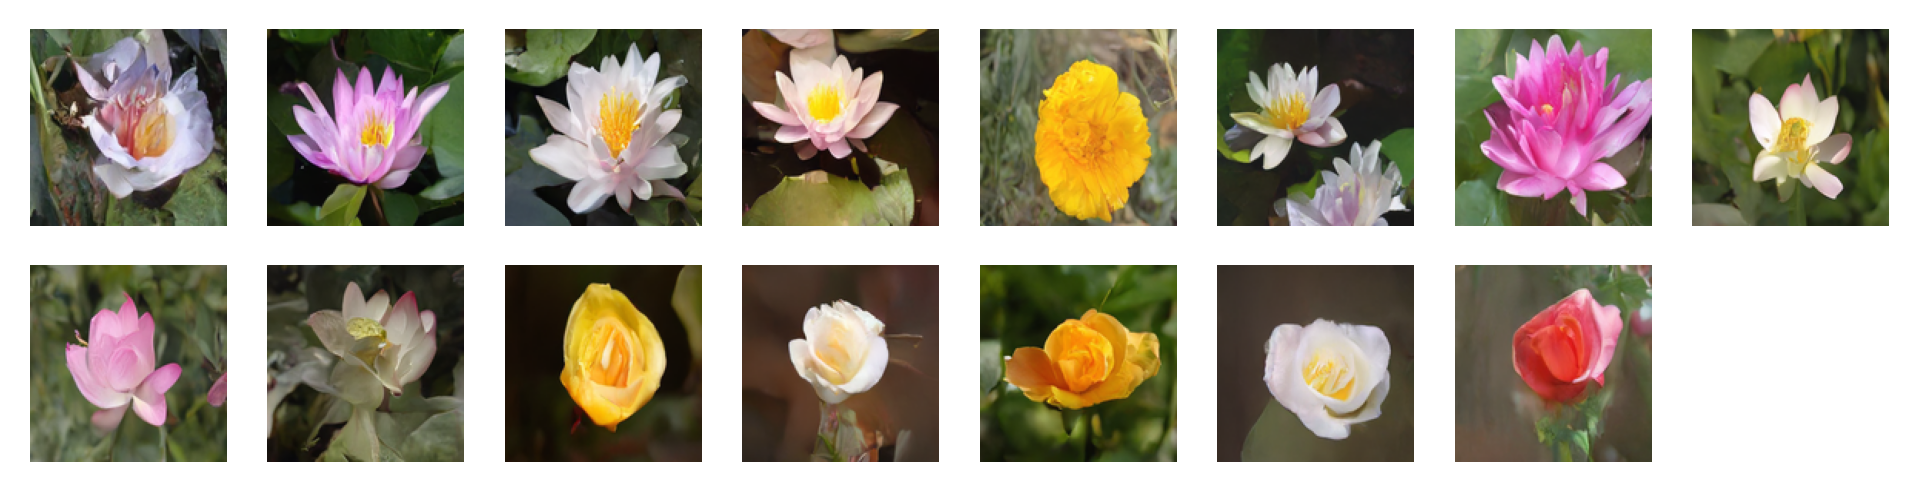

In [45]:
prompts = [
    'water tulip',
    'a water lily',
    'a water lily', 
    'a water lily', 
    'a photo of a marigold', 
    'a water lily',
    'a water lily',
    'a photo of a lotus',
    'a photo of a lotus',
    'a photo of a lotus',
    'a photo of a rose',
    'a photo of a rose',
    'a photo of a rose',
    'a photo of a rose',
    'a photo of a rose',
    ]
pooled_labels, labels_seq = encodePrompts(prompts, textEncoderModel, textTokenizer)

sampler = EulerAncestralSampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform, guidance_scale=2, null_labels_seq=data['null_labels_full'])
samples = sampler.generate_images(num_images=len(prompts), diffusion_steps=200, start_step=1000, end_step=0, priors=None, model_conditioning_inputs=(labels_seq,))
plotImages(samples, dpi=300)

In [46]:
prompts = [
    'water tulip',
    'a water lily',
    'a water lily', 
    'a water lily', 
    'a photo of a marigold', 
    'a water lily',
    'a water lily',
    'a photo of a lotus',
    'a photo of a lotus',
    'a photo of a lotus',
    'a photo of a rose',
    'a photo of a rose',
    'a photo of a rose',
    'a photo of a rose',
    'a photo of a rose',
    ]
pooled_labels, labels_seq = encodePrompts(prompts, textEncoderModel, textTokenizer)

sampler = EulerAncestralSampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform, guidance_scale=7, null_labels_seq=data['null_labels_full'])
samples = sampler.generate_images(num_images=len(prompts), diffusion_steps=200, start_step=1000, end_step=0, priors=None, model_conditioning_inputs=(labels_seq,))
plotImages(samples, dpi=300)

Using classifier-free guidance


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:11<00:00, 17.86it/s]


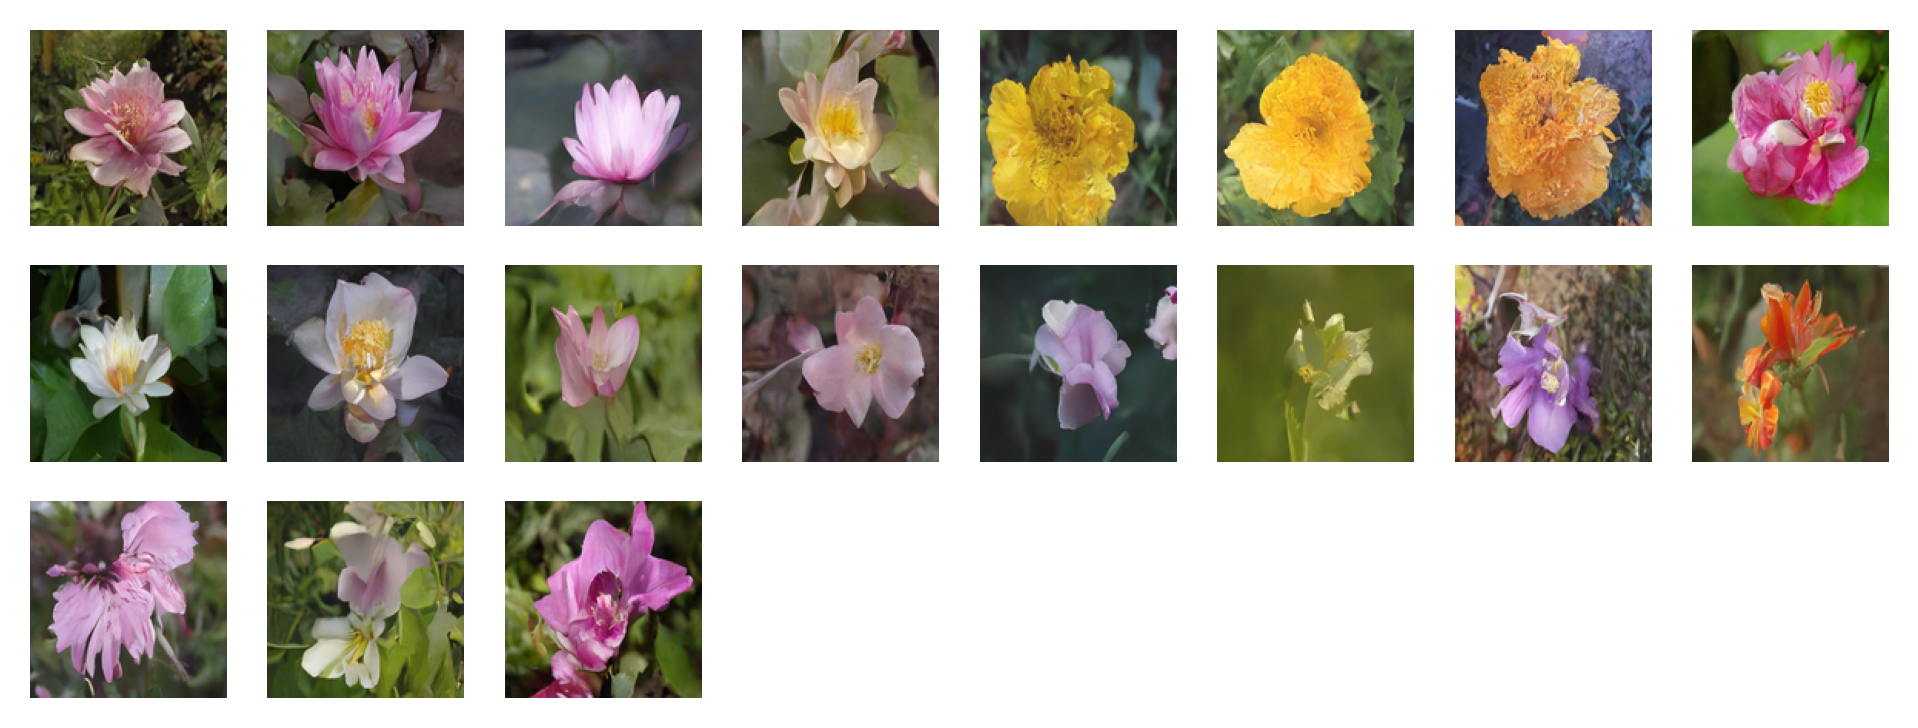

In [23]:
prompts = [
    'water tulip',
    'a water lily',
    'a water lily', 
    'a water lily', 
    'a marigold', 
    'a marigold', 
    'a marigold', 
    'a water lily',
    'a water lily',
    'a photo of a lotus',
    'a photo of a lotus',
    'a photo of a rose',
    'a photo of a rose',
    'a photo of a rose',
    'a photo of a rose',
    "",
    "",
    "",
    "",
    ]
pooled_labels, labels_seq = encodePrompts(prompts, textEncoderModel, textTokenizer)

sampler = EulerAncestralSampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=len(prompts), diffusion_steps=200, start_step=1000, end_step=0, priors=None, model_conditioning_inputs=(labels_seq,))
plotImages(samples, dpi=300)

100%|██████████| 200/200 [00:05<00:00, 33.34it/s]


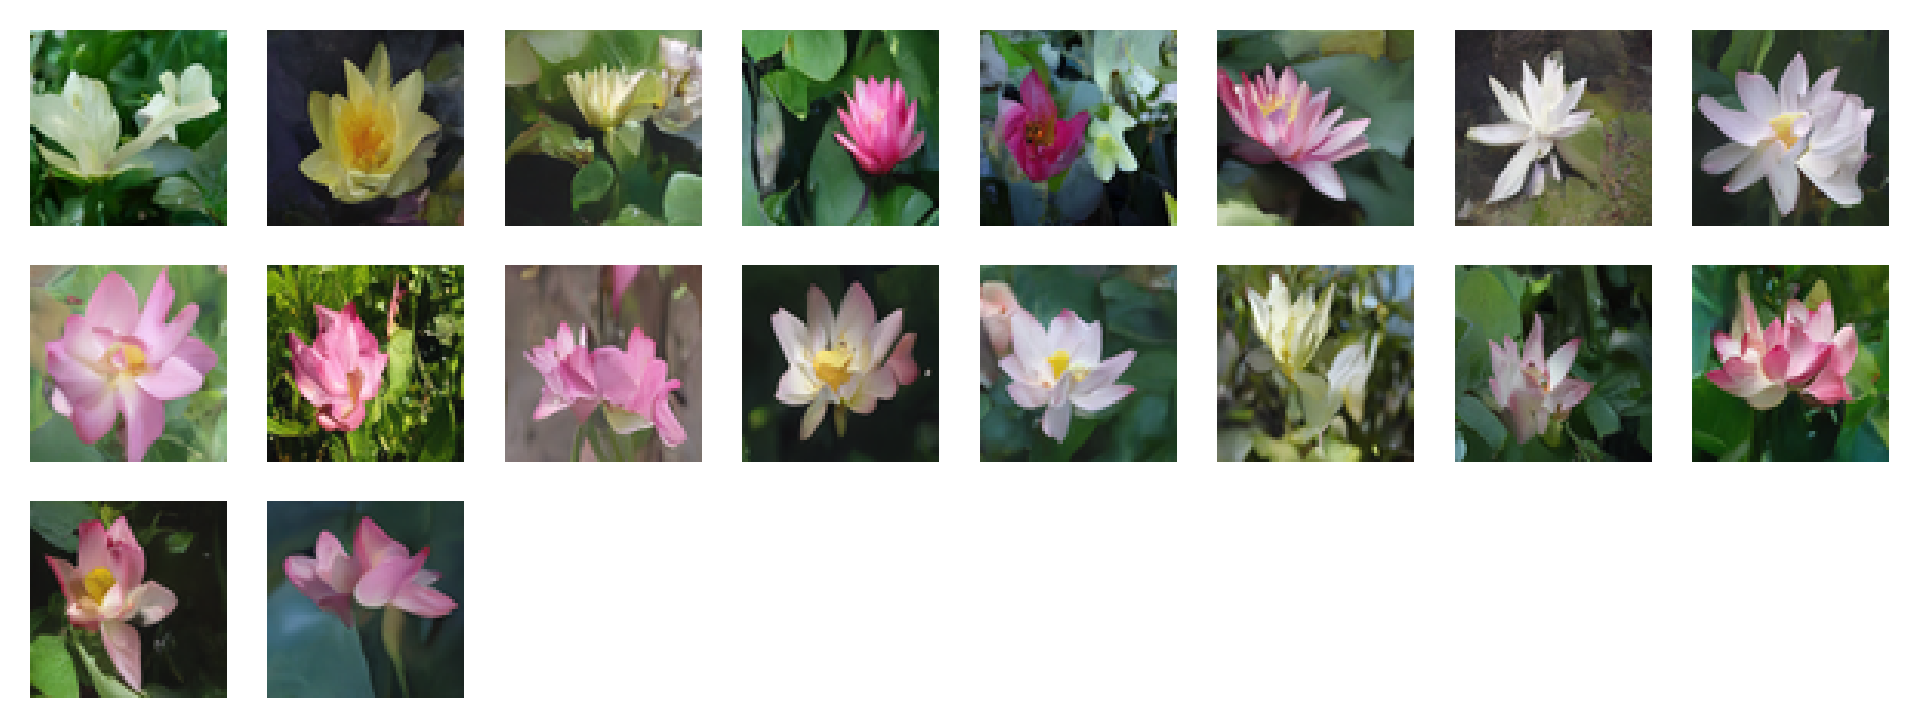

In [48]:
prompts = [
    'water tulip',
    'a water lily',
    'a water lily', 
    'a water lily', 
    'a water lily and a marigold', 
    'a water lily',
    'a water lily',
    'a photo of a lotus',
    'a photo of a lotus',
    'a photo of a lotus',
    'a photo of a lotus',
    'a photo of a lotus',
    'a photo of a lotus',
    'a photo of a lotus',
    'a photo of a lotus',
    'a photo of a lotus',
    'a photo of a lotus',
    'a photo of a lotus',
    ]
embeddings = encodePrompts(prompts, textEncoderModel, textTokenizer)

sampler = EulerAncestralSampler(trainer.model, trainer.best_state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=len(prompts), diffusion_steps=200, start_step=1000, end_step=0, priors=None, model_conditioning_inputs=embeddings)
plotImages(samples, dpi=300)

100%|██████████| 200/200 [00:14<00:00, 13.34it/s]


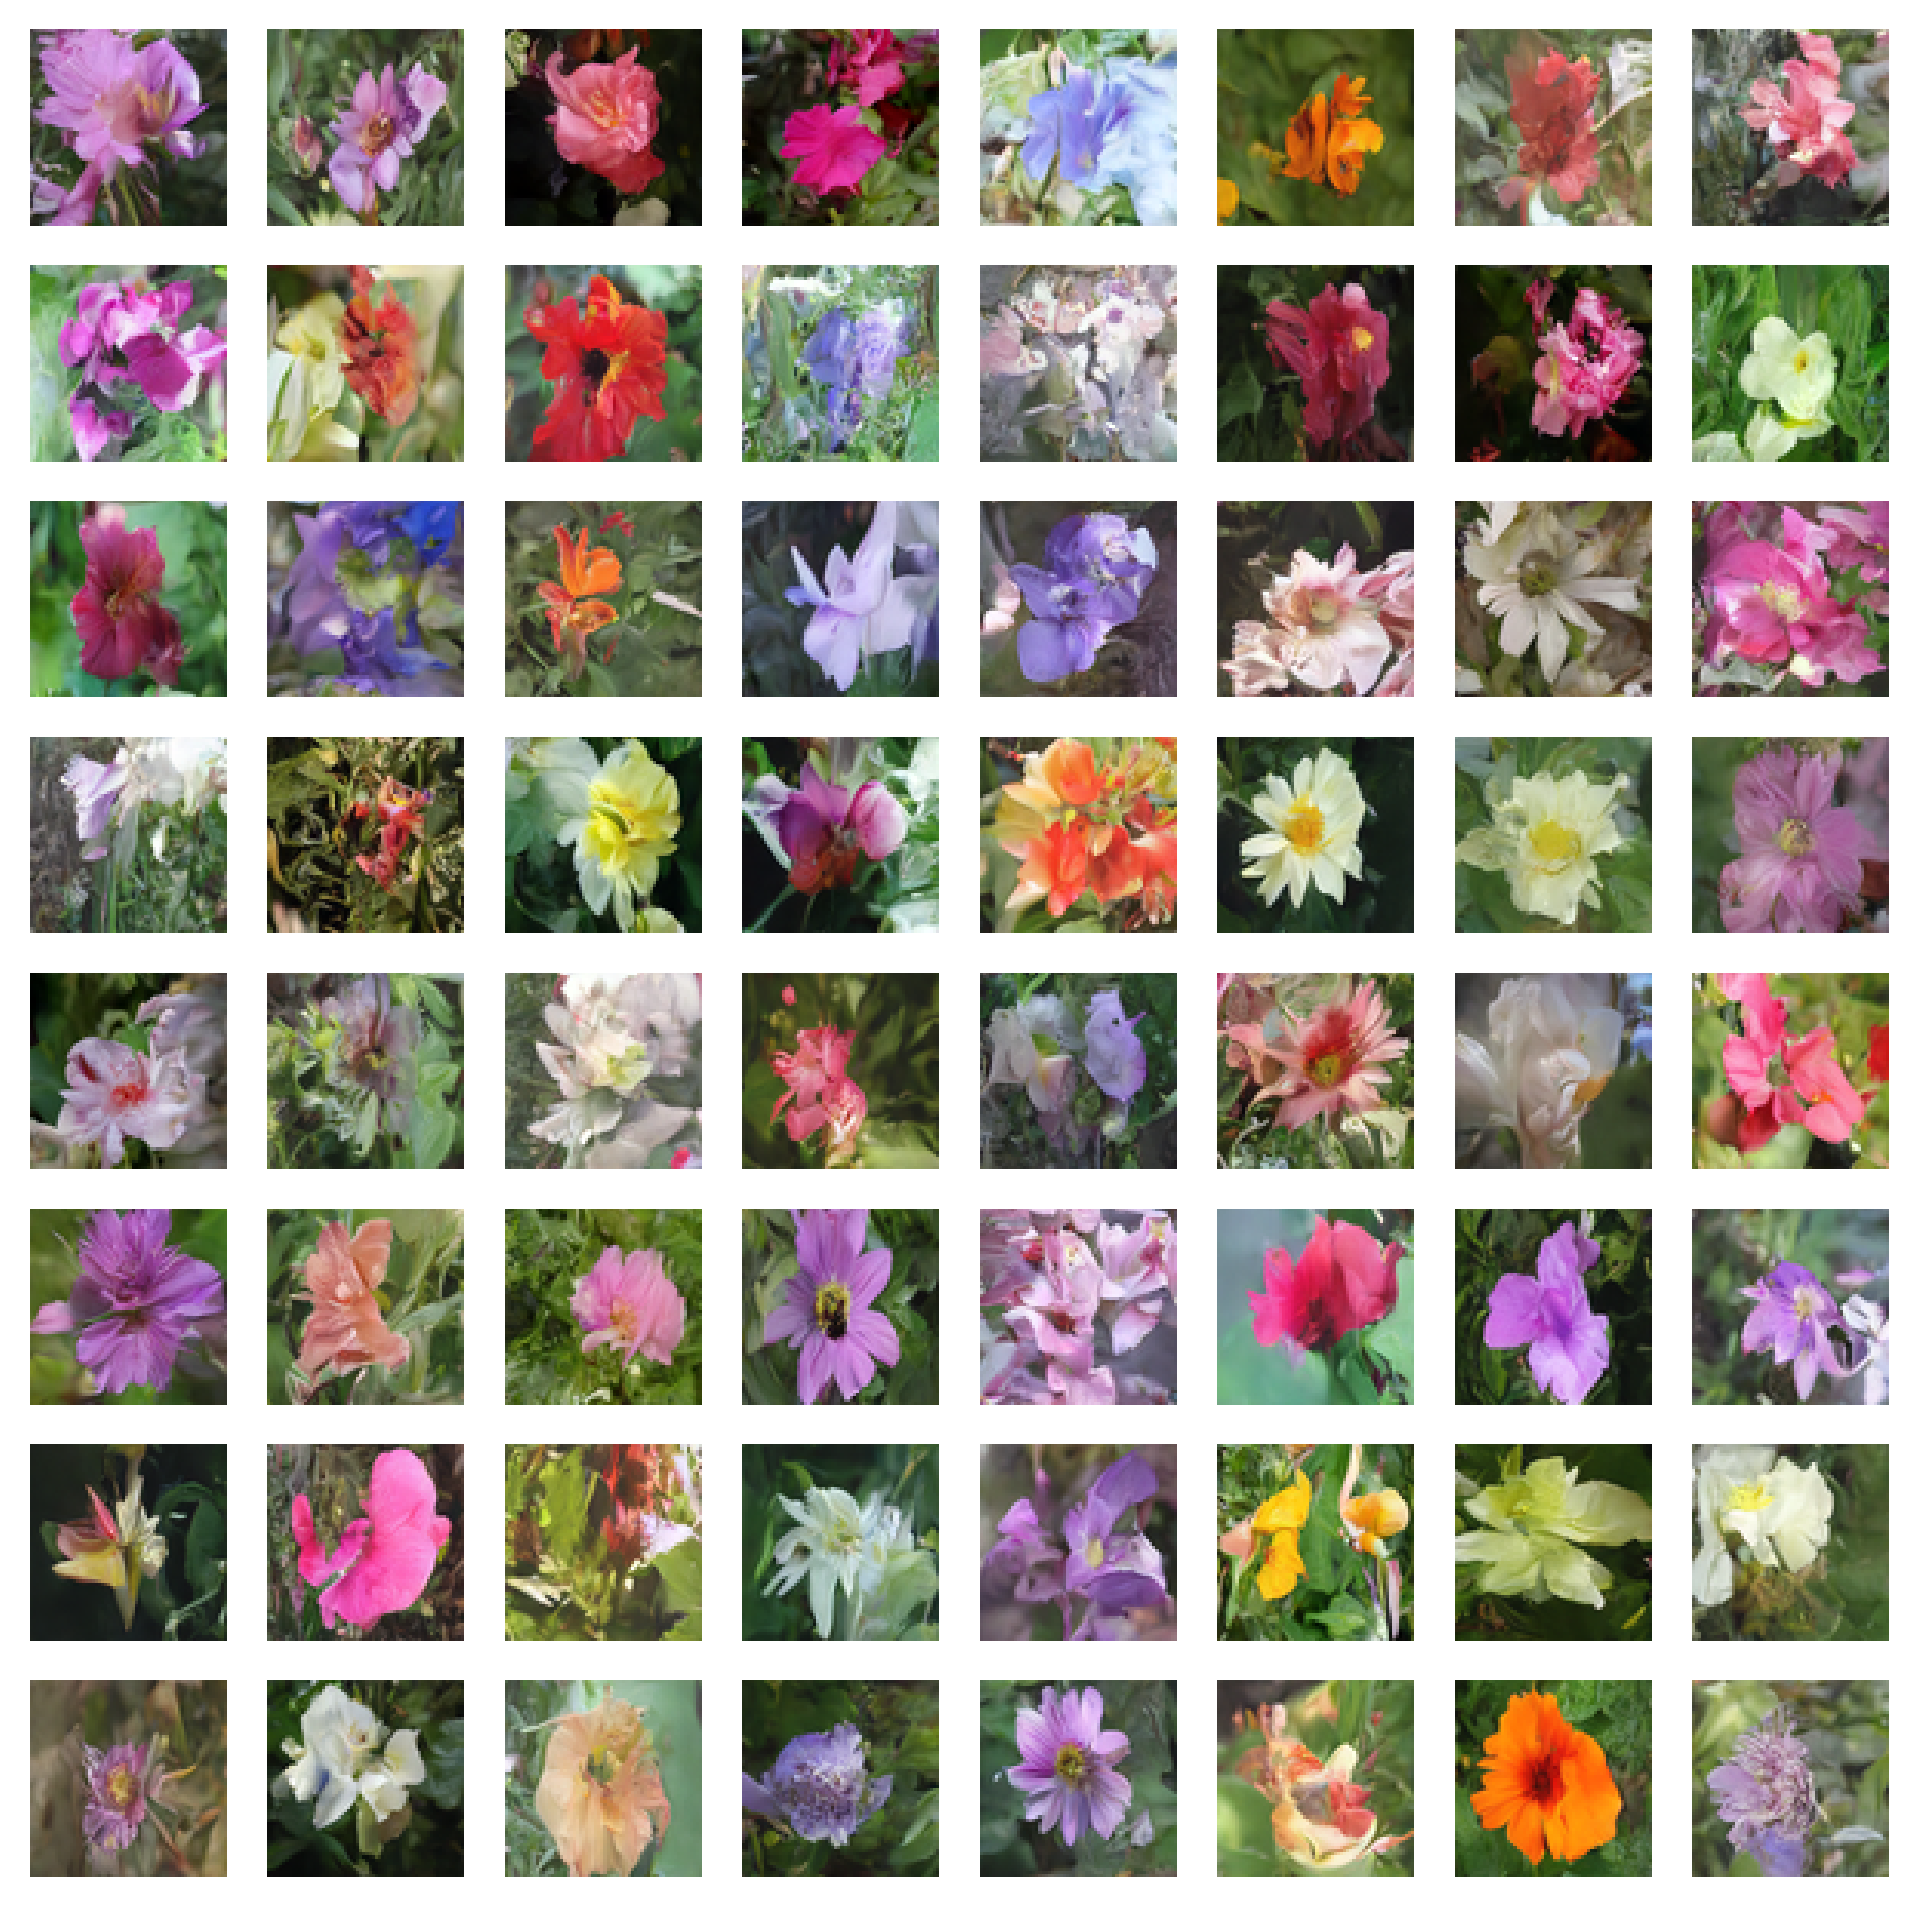

In [20]:
sampler = EulerAncestralSampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=64, diffusion_steps=200, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=300)

In [ ]:
sampler = EulerAncestralSampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=64, diffusion_steps=200, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=300)

In [ ]:
sampler = RK4Sampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=64, diffusion_steps=6, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=300)

In [ ]:
sampler = EulerAncestralSampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=64, diffusion_steps=300, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=300)

In [ ]:
sampler = DDPMSampler(trainer.model, trainer.state.params, trainer.noise_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=16, start_step=1000, priors=None)
plotImages(samples, dpi=300)

In [ ]:
sampler = DDPMSampler(trainer.model, trainer.best_state.params, trainer.noise_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=16, start_step=1000, priors=None)
plotImages(samples, dpi=300)

In [ ]:
sampler = DDPMSampler(trainer.model, trainer.best_state.params, trainer.noise_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=64, start_step=1000, priors=None)
plotImages(samples)